# Optimizing a 3D Unicorn with GEPA

This tutorial uses GEPA's `optimize_anything` to evolve a **complete Python program** that generates a 3D unicorn — **starting from no seed candidate at all**.

The task is to produce a 3D CAD model of a unicorn using [build123d](https://build123d.readthedocs.io/), a Python CAD library for constructive solid geometry. But a CAD model alone is just a mesh — you can't hand it to a VLM for evaluation. To close the loop, the program must also set up a rendering pipeline: export the mesh to STL, load it into [pyrender](https://pyrender.readthedocs.io/), configure materials, position light sources, orbit a camera at multiple angles, and save the resulting screenshots as PNG files. The evaluator then collects those PNGs and sends them to a VLM for scoring. The `background` string tells the optimizer where to save the screenshots so the evaluator knows where to find them.

GEPA's `seed_candidate=None` feature lets the reflection LM bootstrap the initial program from the objective and background alone. Each candidate is a full Python script. When executed, it produces multi-view PNG renderings that are scored by a VLM on 4 aspects (quality, anatomy, mesh, visual appeal). This enables:

- **Zero-shot bootstrap** — no hand-written seed code needed; the LM generates the first candidate
- **Pareto-efficient selection** — a candidate weak on anatomy isn't hidden behind decent mesh quality
- **Minibatch reflection** — GEPA reflects on a subset of aspects each iteration, cycling through all 4
- **Fine-grained feedback** — the reflection LM sees per-aspect scores and rendered images to target the weakest areas

In [2]:
import base64
import glob
import os
import re
import subprocess
import tempfile
from functools import partial

import litellm

from gepa.image import Image
from gepa.optimize_anything import GEPAConfig, EngineConfig, ReflectionConfig, optimize_anything

## Configuration

Pick any VLM supported by [LiteLLM](https://docs.litellm.ai/docs/providers) for evaluation and reflection.

In [3]:
MODEL = "bedrock/us.anthropic.claude-opus-4-6-v1"
GOAL = "a high-quality 3D unicorn"

## Evaluation Aspects (Dataset)

Each aspect becomes a dataset entry. GEPA calls the evaluator **once per aspect per candidate** (4 calls per candidate), tracking scores individually. This is the key difference from averaging scores in a single evaluator call — GEPA can identify that a candidate excels at visual appeal but has broken anatomy.

In [4]:
ASPECTS = [
    {
        "id": "overall",
        "aspect": "Overall Quality & Recognizability",
        "criteria": (
            f"Critically rate the overall quality of this 3D rendering depicting {GOAL}. "
            "Is the unicorn immediately recognizable? Is the scene coherent and well-composed? "
            "SCORE: X/100"
        ),
    },
    {
        "id": "anatomy",
        "aspect": "Unicorn Anatomy",
        "criteria": (
            f"Critically rate the anatomical accuracy of this 3D unicorn ({GOAL}). "
            "Does it have: a single spiral horn on the forehead, four legs, a horse-like body, "
            "a mane, and a tail? Are proportions realistic? SCORE: X/100"
        ),
    },
    {
        "id": "mesh_quality",
        "aspect": "3D Model Quality",
        "criteria": (
            f"Critically rate the 3D model quality of this rendering ({GOAL}). "
            "Is the geometry solid and well-constructed? Is the mesh clean without "
            "floating parts, gaps, or self-intersections? Are surfaces smooth where appropriate? "
            "SCORE: X/100"
        ),
    },
    {
        "id": "visual_appeal",
        "aspect": "Visual Appeal",
        "criteria": (
            f"Critically rate the visual appeal of this 3D rendering ({GOAL}). "
            "Are the materials convincing (metallic, matte, etc.)? Is the lighting "
            "well-balanced with good contrast? Is the composition pleasing across views? Is the unicorn colored (penalize plain appearances)?"
            "SCORE: X/100"
        ),
    },
]

## No Seed Candidate Needed

Unlike the SVG tutorial, we don't provide a seed candidate here. By passing `seed_candidate=None`, GEPA uses the reflection LM to generate the initial Python program from the `objective` and `background` strings alone. This demonstrates GEPA's ability to bootstrap optimization from scratch.

## Evaluator

In dataset mode, GEPA calls this function once per aspect per candidate. The `example` argument is one entry from `ASPECTS`.

The evaluator:
1. Writes the candidate Python code to a temp file
2. Executes it via `subprocess.run(["uv", "run", "python", ...])`
3. Collects all `*.png` files produced
4. Sends the images + aspect criteria to a VLM for scoring
5. Returns `(score, side_info)` with `Image(base64_data=...)` objects so the reflection LM can see the renders

In [5]:
def evaluate(candidate, example, *, model):
    # With seed_candidate=None, candidate is a plain string (the Python code)
    code = candidate

    # Write and execute in a temp directory
    with tempfile.TemporaryDirectory() as tmpdir:
        script_path = os.path.join(tmpdir, "unicorn.py")
        with open(script_path, "w") as f:
            f.write(code)

        proc = subprocess.run(
            ["uv", "run", "python", script_path],
            cwd=tmpdir,
            capture_output=True,
            text=True,
            timeout=120,
        )

        if proc.returncode != 0:
            return 0.0, {
                "Aspect": example["aspect"],
                "Score": "0.00",
                "Error": proc.stderr[-2000:] if proc.stderr else "Unknown error",
            }

        # Collect all rendered PNG files
        png_files = sorted(glob.glob(os.path.join(tmpdir, "*.png")))
        if not png_files:
            return 0.0, {
                "Aspect": example["aspect"],
                "Score": "0.00",
                "Error": "No PNG files produced",
                "stdout": proc.stdout[-1000:],
            }

        # Encode images and build VLM message content
        images = []
        content = [{"type": "text", "text": example["criteria"]}]
        for png_path in png_files:
            with open(png_path, "rb") as f:
                b64 = base64.b64encode(f.read()).decode()
            images.append(Image(base64_data=b64, media_type="image/png"))
            content.append(
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}}
            )

    # Ask VLM to score
    resp = litellm.completion(
        model=model,
        messages=[{"role": "user", "content": content}],
    )
    text = resp.choices[0].message.content

    # Parse score (try X/100 first, then X/10)
    m = re.search(r"(\d+(?:\.\d+)?)\s*/\s*100", text)
    divisor = 100 if m else 10
    if not m:
        m = re.search(r"(\d+(?:\.\d+)?)\s*/\s*10", text)
    score = max(0.0, min(1.0, float(m.group(1)) / divisor)) if m else 0.0

    # Build side_info with images so the reflection LM can see the renders
    side_info = {
        "Aspect": example["aspect"],
        "Score": f"{score:.2f}",
        "Feedback": text,
    }
    for i, img in enumerate(images):
        side_info[f"RenderedView{i + 1}"] = img

    return score, side_info

## Zero-Shot Baseline

Before running GEPA, let's see what the model produces in a single shot — no iteration, no feedback.

In [ ]:
from IPython.display import display, Image as IPImage

resp = litellm.completion(
    model=MODEL,
    messages=[{"role": "user", "content": (
        f"Generate a complete Python program that creates {GOAL} using build123d for CSG geometry "
        "and pyrender for multi-view rendering. The program should:\n"
        "- Use BuildPart() context manager for geometry\n"
        "- Export to STL via export_stl(), load with trimesh, render with pyrender\n"
        "- Render 3 views at different angles and save as .png files\n"
        "- Use MetallicRoughnessMaterial for realistic materials\n\n"
        "Output ONLY the Python code, no explanation."
    )}],
)
zero_shot_code = resp.choices[0].message.content

# Strip markdown fences if present
code_match = re.search(r"```(?:python)?\s*\n(.*?)```", zero_shot_code, re.DOTALL)
if code_match:
    zero_shot_code = code_match.group(1)

with open("zero_shot_unicorn.py", "w") as f:
    f.write(zero_shot_code)

# Execute and display
with tempfile.TemporaryDirectory() as tmpdir:
    script_path = os.path.join(tmpdir, "unicorn.py")
    with open(script_path, "w") as f:
        f.write(zero_shot_code)

    proc = subprocess.run(
        ["uv", "run", "python", script_path],
        cwd=tmpdir,
        capture_output=True,
        text=True,
        timeout=120,
    )
    print(proc.stdout)
    if proc.returncode != 0:
        print("STDERR:", proc.stderr[-2000:])
    else:
        for png_path in sorted(glob.glob(os.path.join(tmpdir, "*.png"))):
            print(os.path.basename(png_path))
            display(IPImage(filename=png_path))

## Run Optimization

Key parameters:

- **`seed_candidate=None`** — GEPA generates the initial Python program via the reflection LM
- **`dataset`** — passing our 4 aspects enables per-aspect Pareto selection
- **`reflection_minibatch_size=1`** — each aspect already includes 3 rendered views in side_info, so we reflect on 1 aspect at a time to keep image count manageable (1 × 3 = 3 images per reflection)
- **`raise_on_exception=False`** — evolved code may have syntax/runtime errors; GEPA assigns score 0 and continues
- **`objective` / `background`** — provides the reflection LM with enough context to generate and improve the program

In [ ]:
result = optimize_anything(
    seed_candidate=None,  # LM generates the initial program from objective + background
    evaluator=partial(evaluate, model=MODEL),
    dataset=ASPECTS,
    objective=(
        "Optimize a Python program that generates a high-quality 3D unicorn. "
        "The program uses build123d for CSG geometry (Box, Cylinder, Cone, Sphere, Fillet, etc.) "
        "and pyrender for multi-view rendering. Output ONLY valid Python code."
    ),
    background=(
        "The candidate is a complete Python script. When executed, it must produce multi-view "
        "PNG renderings of a 3D unicorn in its working directory. Images are scored 0-100 by a VLM.\n\n"
        "Technical requirements:\n"
        "- Use build123d (BuildPart context manager) for constructive solid geometry\n"
        "- Export to STL via export_stl(), then load with trimesh and render with pyrender\n"
        "- Render 3 views at different angles using pyrender.OffscreenRenderer\n"
        "- Save output as .png files in the current working directory\n"
        "- Use pyrender.MetallicRoughnessMaterial for realistic materials\n"
        "- Available build123d shapes: Box, Cylinder, Cone, Sphere, Torus, Fillet, Chamfer, Loft, Sweep, etc.\n\n"
        "Known working imports:\n"
        "```python\n"
        "import numpy as np\n"
        "import pyrender\n"
        "import trimesh\n"
        "from build123d import (\n"
        "    Align,\n"
        "    Box,\n"
        "    BuildPart,\n"
        "    Cone,\n"
        "    Cylinder,\n"
        "    Location,\n"
        "    Locations,\n"
        "    Rotation,\n"
        "    export_stl,\n"
        ")\n"
        "from PIL import Image\n"
        "```"
    ),
    config=GEPAConfig(
        engine=EngineConfig(
            max_metric_calls=200,
            raise_on_exception=False,
            run_dir="./runs/3d_unicorn",
        ),
        reflection=ReflectionConfig(
            reflection_lm=MODEL,
            reflection_minibatch_size=1,  # each aspect already sends 3 rendered views
        ),
    ),
)

## Results

In [8]:
print(f"Best score: {result.val_aggregate_scores[result.best_idx]:.3f}")
print(f"Candidates evaluated: {result.num_candidates}")

for i, score in enumerate(result.val_aggregate_scores):
    marker = " <-- best" if i == result.best_idx else ""
    print(f"  [{i}] {score:.3f}{marker}")

Best score: 0.255
Candidates evaluated: 5
  [0] 0.000
  [1] 0.087
  [2] 0.203
  [3] 0.255 <-- best
  [4] 0.015


### What GEPA Discovered

Starting from **no seed code at all**, GEPA's reflection LM bootstrapped an initial Python program and iteratively refined it. The first candidate (index 0) scored 0.0 — it crashed on execution. By candidate 3, GEPA had evolved a **600+ line program** with:

- **Anatomically structured geometry**: Instead of a few boxy primitives, the evolved program builds the unicorn from hundreds of overlapping spheres that approximate smooth organic surfaces — a body barrel with profile-varying radii, a muscular arching neck, a tapered snout with cheeks, nostrils, and a jaw.
- **Proper horse anatomy**: Four articulated legs with hip joints, upper/lower bones, knees, ankles, and hooves. Each leg has distinct muscle definition (forearm muscles on front legs, haunch muscles on rear legs).
- **A spiral horn**: Not just a cone, but a cone with 18 small spheres tracing a spiral ridge around it.
- **Flowing mane and tail**: The mane follows the neck crest with hair strands cascading to one side (using sinusoidal wave offsets). The tail arcs up from the base and cascades down with spread volume.
- **Multi-light rendering**: Key light, fill light, rim light, under fill, side fill, and front fill — six lights total for studio-quality illumination, compared to the typical 2-light setup.
- **Mesh post-processing**: Laplacian smoothing to soften the CSG union artifacts.

None of this was in any seed — GEPA discovered it all through the evaluate → reflect → mutate loop, guided by VLM feedback on the rendered images.

In [9]:
best_code = result.best_candidate  # plain string when seed_candidate=None

with open("best_unicorn.py", "w") as f:
    f.write(best_code)

print(f"Saved best program to best_unicorn.py ({len(best_code)} chars)")

Saved best program to best_unicorn.py (20588 chars)


### Run the Best Program and Display Results

Building unicorn geometry...
Exporting to unicorn.stl...
Loading mesh...
Setting up pyrender scene...
Saved unicorn_view_0_side_view.png
Saved unicorn_view_1_front_quarter.png
Saved unicorn_view_2_rear_quarter.png
Done! Unicorn rendered successfully.

unicorn_view_0_side_view.png


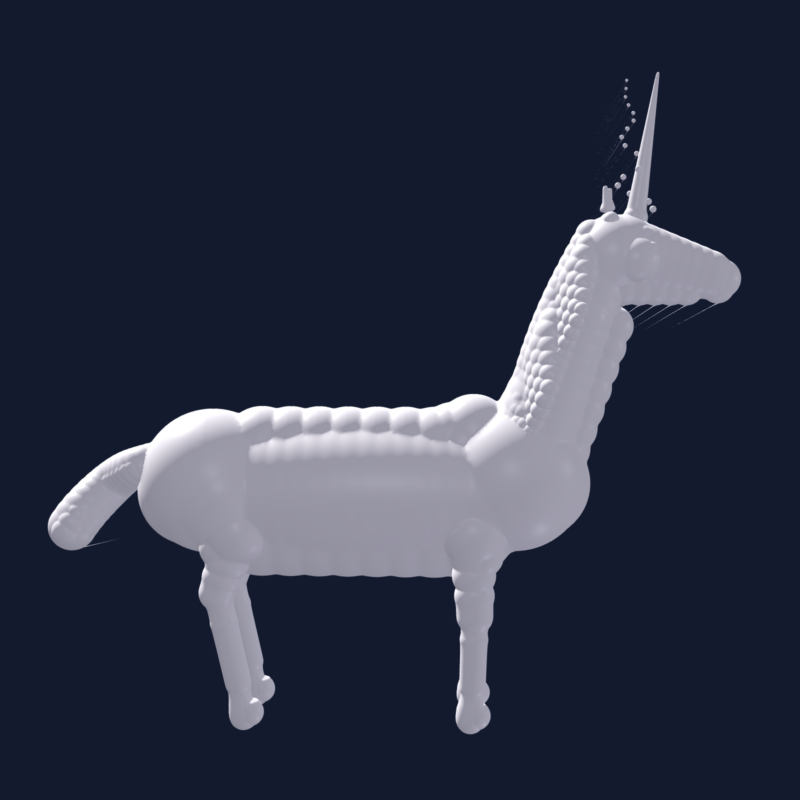

unicorn_view_1_front_quarter.png


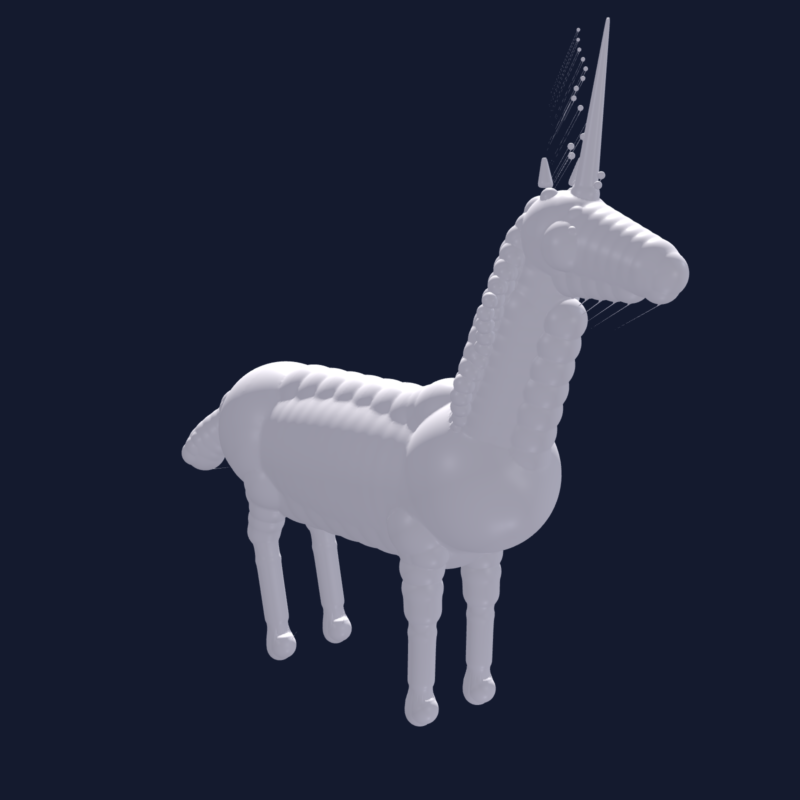

unicorn_view_2_rear_quarter.png


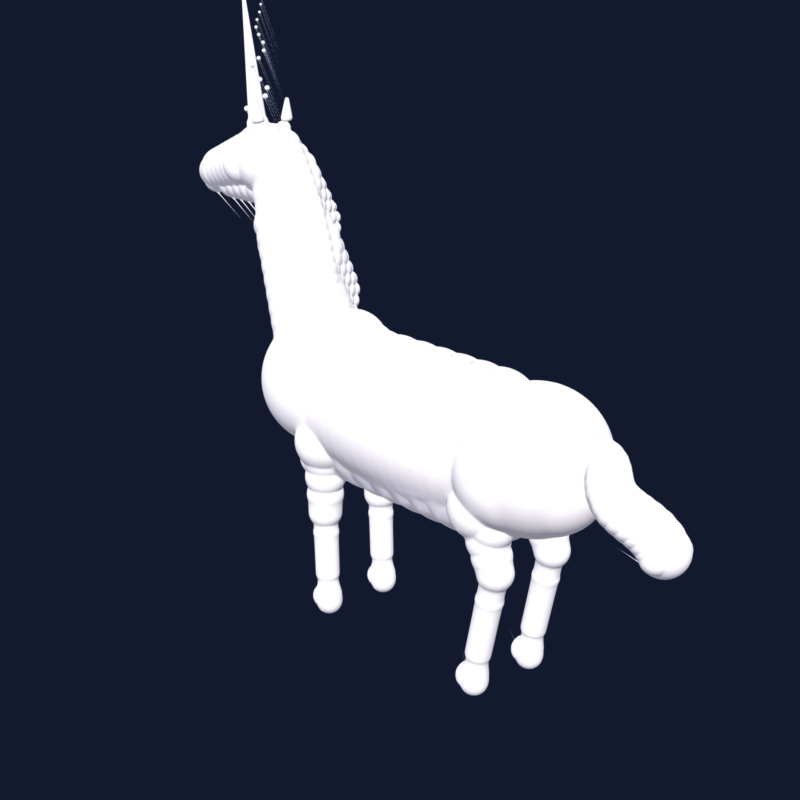

In [11]:
from IPython.display import display, Image as IPImage
import shutil

curr_dir = os.getcwd()

with tempfile.TemporaryDirectory() as tmpdir:
    script_path = os.path.join(tmpdir, "best_unicorn.py")
    with open(script_path, "w") as f:
        f.write(best_code)

    proc = subprocess.run(
        ["uv", "run", "python", script_path],
        cwd=tmpdir,
        capture_output=True,
        text=True,
        timeout=120,
    )
    print(proc.stdout)
    if proc.returncode != 0:
        print("STDERR:", proc.stderr[-2000:])
    else:
        for png_path in sorted(glob.glob(os.path.join(tmpdir, "*.png"))):
            print(os.path.basename(png_path))

            shutil.copy(png_path, os.path.join(curr_dir, os.path.basename(png_path)))
            
            display(IPImage(filename=png_path))